In [83]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchprofile import profile_macs
from typing import Union, List
from tqdm import tqdm
import math
import copy
import ray
from ray.tune.search import ConcurrencyLimiter
from ray import tune
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.bayesopt import BayesOptSearch
import os
import random
import config
import pathlib
from torch.optim.lr_scheduler import StepLR
from onnxruntime.quantization import quantize_static, QuantFormat, QuantType, CalibrationMethod
from onnxruntime import quantization
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [134]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        # First convolutional layer
        self.conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=2, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=16, stride=16)
        # Fully connected layer 1
        self.fc = nn.Linear(6 * 2 * 2, 10)

    def forward(self, x):
        # Apply first convolutional layer followed by ReLU and max pooling
        x = self.pool(F.relu(self.conv(x)))
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 6 * 2 * 2)
        # Apply the first fully connected layer followed by ReLU
        x = self.fc(x)
        return x

# Example of creating a model and printing the size
model = SimpleCNN()
print(model)

# Checking model's parameter size
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {params}")

# Example of saving the model
torch.save(model.state_dict(), 'SimpleCNN.pt')

SimpleCNN(
  (conv): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=24, out_features=10, bias=True)
)
Number of parameters: 328


Files already downloaded and verified
Files already downloaded and verified


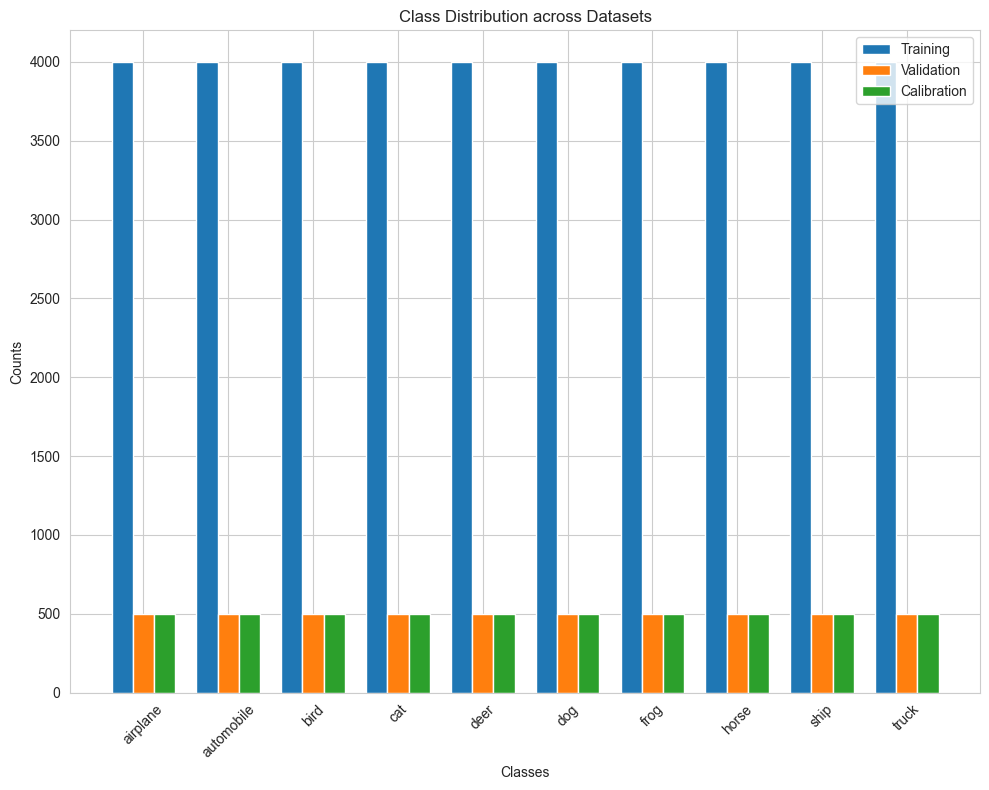

In [114]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize each channel
])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Organize data by class
class_indices = [[] for _ in range(10)]  # CIFAR-10 has 10 classes
for i in range(len(training_dataset)):
    _, label = training_dataset[i]
    class_indices[label].append(i)

# Redefine the splits based on the new requirements
train_indices = []
validation_indices = []
calibration_indices = []

# Split each class into the required parts
for indices in class_indices:
    np.random.shuffle(indices)
    train_indices.extend(indices[:4000])  # First 4000 of each class to the training set
    validation_indices.extend(indices[4000:4500])  # Next 500 of each class to the validation set
    calibration_indices.extend(indices[4500:5000])  # Last 500 of each class to the calibration set

# Create subsets for each set
train_dataset = Subset(training_dataset, train_indices)  # Redefined to use train_data if not already defined
validation_dataset = Subset(training_dataset, validation_indices)
calibration_dataset = Subset(training_dataset, calibration_indices)

# Optional: To verify the distribution
def verify_distribution(dataset):
    # This assumes that the dataset passed is a Subset of CIFAR-10
    class_counts = [0] * 10
    for i in dataset.indices:
        _, label = training_dataset[i]  # Assuming train_data is your original CIFAR-10 dataset
        class_counts[label] += 1
    return class_counts


train_counts = verify_distribution(train_dataset)
valid_counts = verify_distribution(validation_dataset)
calib_counts = verify_distribution(calibration_dataset)

# Classes in CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Set the positions and width for the bars
ind = range(len(classes))  # the x locations for the groups
width = 0.25  # the width of the bars

# Plotting
train_bars = ax.bar(ind, train_counts, width, label='Training')
validation_bars = ax.bar([p + width for p in ind], valid_counts, width, label='Validation')
calibration_bars = ax.bar([p + width * 2 for p in ind], calib_counts, width, label='Calibration')

# Add some text for labels, title and axes ticks
ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Class Distribution across Datasets')
ax.set_xticks([p + width for p in ind])
ax.set_xticklabels(classes)
ax.legend()

# Rotation of the bars names
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [135]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='simpleCNN_v1.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                torch.save(model.state_dict(), self.path)
                self.best_loss = val_loss
            self.counter = 0

device = torch.device('mps')  # or 'cuda' if using NVIDIA GPUs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
early_stopping = EarlyStopping(patience=10, verbose=True)

def train(model, epoch, val_loader, train_loader):  # Loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch}, Train Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_accuracy}%')

    # Early Stopping
    early_stopping(val_loss / len(val_loader), model)
    if early_stopping.early_stop:
        print("Early stopping")
        return True
    return False

#dataloaders
batch_size = 64  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
calibration_loader = DataLoader(calibration_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)
model.to(device)
# Update the loop to handle early stopping
early_stopped = False
for epoch in tqdm(range(20)):
    if train(model, epoch, validation_loader, train_loader):
        early_stopped = True
        break

if early_stopped:
    print('Loading the best model...')
    model.load_state_dict(torch.load(early_stopping.path))  # Load the best model

  5%|▌         | 1/20 [00:06<01:59,  6.31s/it]

Epoch 0, Train Loss: 2.144256509399414, Validation Loss: 2.0458886653562134, Validation Accuracy: 26.62%


 10%|█         | 2/20 [00:12<01:57,  6.53s/it]

Epoch 1, Train Loss: 2.0002076873779298, Validation Loss: 1.9765479459038264, Validation Accuracy: 28.96%


 15%|█▌        | 3/20 [00:19<01:52,  6.61s/it]

Epoch 2, Train Loss: 1.951912014579773, Validation Loss: 1.9416702321813077, Validation Accuracy: 29.62%


 20%|██        | 4/20 [00:26<01:45,  6.57s/it]

Epoch 3, Train Loss: 1.926726601409912, Validation Loss: 1.9334763409216194, Validation Accuracy: 30.72%


 25%|██▌       | 5/20 [00:32<01:37,  6.52s/it]

Epoch 4, Train Loss: 1.9114585647583007, Validation Loss: 1.9215211536310897, Validation Accuracy: 30.86%


 30%|███       | 6/20 [00:39<01:32,  6.60s/it]

Epoch 5, Train Loss: 1.9016075275421143, Validation Loss: 1.9138063358355173, Validation Accuracy: 31.46%


 35%|███▌      | 7/20 [00:46<01:26,  6.62s/it]

Epoch 6, Train Loss: 1.895589855003357, Validation Loss: 1.9079382691202285, Validation Accuracy: 31.78%


 40%|████      | 8/20 [00:52<01:17,  6.49s/it]

Epoch 7, Train Loss: 1.8914454793930053, Validation Loss: 1.9074112976653665, Validation Accuracy: 31.58%


 45%|████▌     | 9/20 [00:58<01:10,  6.38s/it]

Epoch 8, Train Loss: 1.8885563703536987, Validation Loss: 1.9012370592431178, Validation Accuracy: 32.0%


 50%|█████     | 10/20 [01:04<01:02,  6.27s/it]

Epoch 9, Train Loss: 1.88666637840271, Validation Loss: 1.9039618833155572, Validation Accuracy: 31.86%


 55%|█████▌    | 11/20 [01:10<00:55,  6.12s/it]

Epoch 10, Train Loss: 1.885383846092224, Validation Loss: 1.9008386693423307, Validation Accuracy: 31.9%


 60%|██████    | 12/20 [01:16<00:48,  6.09s/it]

Epoch 11, Train Loss: 1.8844458721160888, Validation Loss: 1.900397923928273, Validation Accuracy: 31.94%


 65%|██████▌   | 13/20 [01:22<00:43,  6.17s/it]

Epoch 12, Train Loss: 1.8838094692230225, Validation Loss: 1.898332547537888, Validation Accuracy: 31.94%


 70%|███████   | 14/20 [01:29<00:38,  6.36s/it]

Epoch 13, Train Loss: 1.883360283088684, Validation Loss: 1.8960535963879357, Validation Accuracy: 32.0%


 75%|███████▌  | 15/20 [01:35<00:31,  6.30s/it]

Epoch 14, Train Loss: 1.8830518083572387, Validation Loss: 1.9003719830814796, Validation Accuracy: 32.04%


 80%|████████  | 16/20 [01:41<00:24,  6.19s/it]

Epoch 15, Train Loss: 1.8828347661972047, Validation Loss: 1.8919623320615744, Validation Accuracy: 32.04%


 85%|████████▌ | 17/20 [01:47<00:18,  6.15s/it]

Epoch 16, Train Loss: 1.8826824182510375, Validation Loss: 1.9000562112542647, Validation Accuracy: 32.08%


 90%|█████████ | 18/20 [01:53<00:12,  6.10s/it]

Epoch 17, Train Loss: 1.882575994682312, Validation Loss: 1.9014735433119763, Validation Accuracy: 32.1%


 95%|█████████▌| 19/20 [01:59<00:06,  6.06s/it]

Epoch 18, Train Loss: 1.882502480316162, Validation Loss: 1.8995460860336884, Validation Accuracy: 32.1%


100%|██████████| 20/20 [02:05<00:00,  6.27s/it]

Epoch 19, Train Loss: 1.882451333427429, Validation Loss: 1.9006123256079759, Validation Accuracy: 32.08%


Accuracy of the model on the test images: 33.32 %


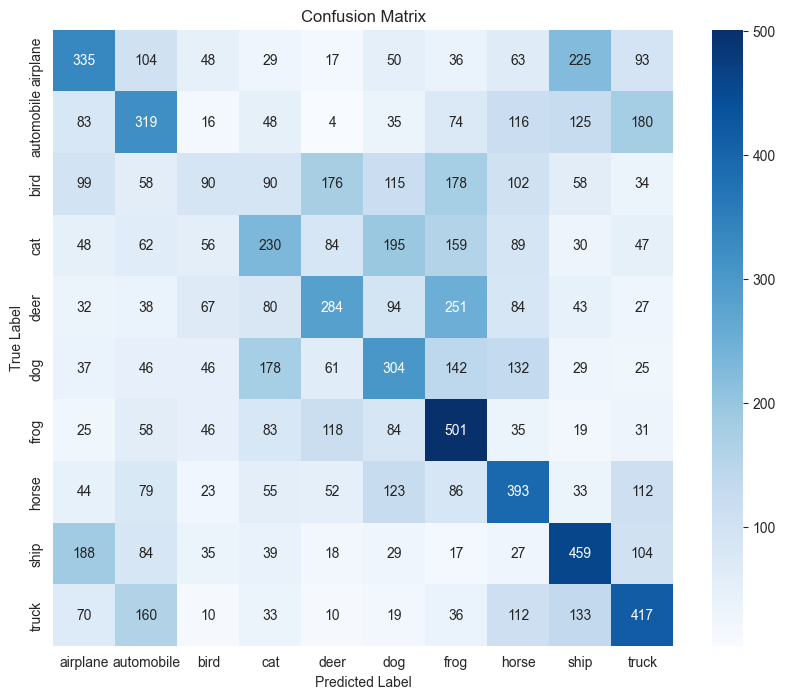

Precision (weighted): 0.3238475671235791
Recall (weighted): 0.3332
F1 Score (weighted): 0.32377664088399016


33.32

In [141]:
def test(model, test_loader, device, display_metric=False):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append to lists
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy} %')

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Plotting the confusion matrix
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    if display_metric == True:
      plt.figure(figsize=(10, 8))
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
      plt.title("Confusion Matrix")
      plt.xlabel("Predicted Label")
      plt.ylabel("True Label")
      plt.show()

    # Print precision, recall, and F1 score
    print(f'Precision (weighted): {precision}')
    print(f'Recall (weighted): {recall}')
    print(f'F1 Score (weighted): {f1}')
    return accuracy

# Replace 'path_to_your_model.pt' with the actual path to your .pt file
model.load_state_dict(torch.load('simpleCNN_v1.pt'))
model.to(device)
test(model, test_loader, device, display_metric=True)

Accuracy of the model on the test images: 33.32 %


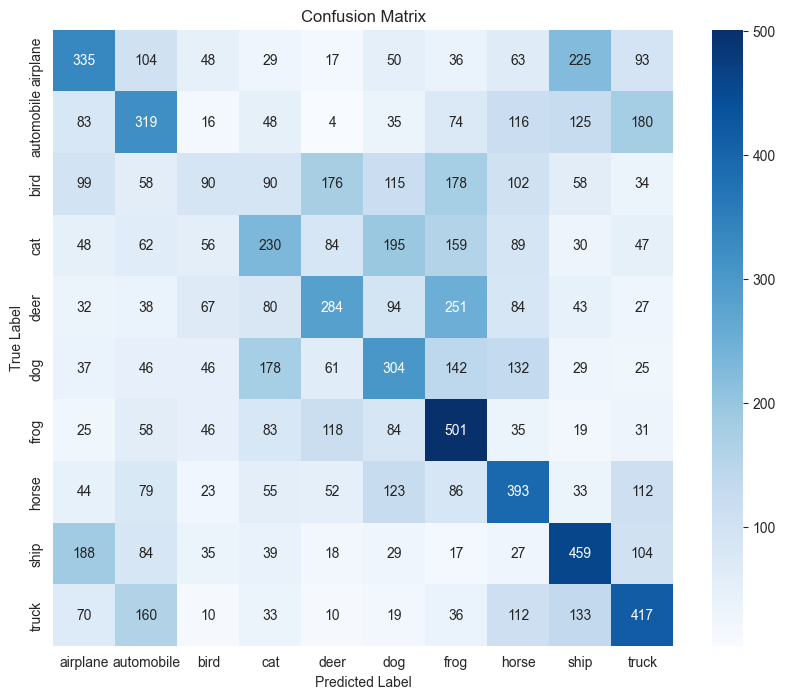

Precision (weighted): 0.3238475671235791
Recall (weighted): 0.3332
F1 Score (weighted): 0.32377664088399016


33.32

In [145]:
def test(model, test_loader, device, display_metric=False):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Append to lists
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy} %')

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Plotting the confusion matrix
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    if display_metric == True:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

    # Print precision, recall, and F1 score
    print(f'Precision (weighted): {precision}')
    print(f'Recall (weighted): {recall}')
    print(f'F1 Score (weighted): {f1}')

    # Save a sample with correct prediction
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Loop through the batch and save the first sample with correct prediction
        for i in range(images.size(0)):
            if predicted[i] == labels[i]:
                # Save the sample
                torch.save({
                    'inputs': images[i:i+1],
                    'labels': labels[i:i+1],
                    'outputs': outputs[i:i+1],
                    'predicted': predicted[i:i+1]
                }, 'correct_test_sample.pt')
                break
        else:
            continue
        break

    return accuracy

# Replace 'path_to_your_model.pt' with the actual path to your .pt file
model.load_state_dict(torch.load('simpleCNN_v1.pt'))
model.to(device)
test(model, test_loader, device, display_metric=True)

In [137]:
 # convert to ONNX
# model.load_state_dict(torch.load('resnet8v1_Pruned_model.pt'))
model.load_state_dict(torch.load('SimpleCNN.pt'))
model.to(torch.device('cpu'))
# Input to the model
x = torch.randn(1, 3, 32, 32, requires_grad=False).to(torch.device('cpu'))
# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "BasicCNN_v1.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=13,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})


In [138]:
class CIFAR10CalibrationDataReader:
    def __init__(self, calibration_dataset):
        self.dataloader = DataLoader(calibration_dataset, batch_size=1, shuffle=False, num_workers=12)
        self.dataiter = iter(self.dataloader)

    def get_next(self):
        try:
            images, _ = next(self.dataiter)
            return {'input': images.numpy()}
        except StopIteration:
            return None

# Define paths
model_input_path = "BasicCNN_v1.onnx"
model_prep_path = 'BasicCNN_prep.onnx'
model_output_path = "BasicCNN_v1_opt.onnx"

quantization.shape_inference.quant_pre_process(model_input_path, model_prep_path, skip_symbolic_shape=False)

calibration_data_reader = CIFAR10CalibrationDataReader(calibration_dataset)
quantize_static(
            model_input=model_prep_path,
            model_output=model_output_path,
            calibration_data_reader=calibration_data_reader,
            quant_format=QuantFormat.QDQ,  # Recommended quant format
            per_channel=True,  # Recommended to use per-channel quantization for weights
            weight_type=QuantType.QInt8,  # Recommended weight type
            activation_type=QuantType.QInt8,  # Recommended activation type
            calibrate_method=CalibrationMethod.MinMax,  # Example calibration method, choose based on your preference
            nodes_to_quantize=None,  # Specify if you have specific nodes to quantize
            nodes_to_exclude=None  # Specify if you have nodes to exclude from quantization
        )